<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/practicals/P5.2_VAE_Anomaly_detection_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 5.2: Anomaly Detection with VAEs

As we have seen, Variational Autoencoders (VAEs) provide a mathematically grounded framework for the unsupervised learning of latent representations. Besides interpreting VAEs as representation learning or generative modelling, we can also see them as performing (approximate) density estimation. VAEs are trained to optimise a lower bound to the (log) likelihood $\log p(X)$ of the data $X$, under the chosen model. So, for any point in data space, we can obtain an estimate of its likelihood under the trained model, by simply computing the loss function when passing this data point through the neural network (note that the loss function is the negative ELBO, so we need to multiply by -1 to obtain a likelihood estimation).

We can use this idea to perform unsupervised anomaly detection. Suppose we are given a dataset that describes some natural distribution (e.g. images of certain clothing items). For new test data, we then wish to detect whether it fits this distribution, or is significantly different (an anomaly). For example, given a dataset of shirts, we want to detect anomalies in a test data set that also contains some images of trousers. Typically, such a situation occurs when we have many examples of one class (e.g. shirts), but very few of others (the anomalies, e.g. trousers).

### Why generative models?
We could describe anomaly detection as binary classification, and train typical supervised methods on data with labels (normal vs. anomaly). However, anomaly detection settings typically have high data imbalance; there are way more normal examples than anomalies. Moreover, anomalies tend to be diverse; there are many ways in which anomalous data can differ from normal data. Supervised methods often don't work well in such cases, and may overfit easily, especially on the anomaly class. Using generative models however, we can ignore the anomaly class completely during training and instead focus on modelling the normal class well. If a generative model can learn to represent normal data well, but is restrictive enough such that it won't be able to represent anomalous data well, it can be much more reliable for anomaly detection.

### Exploring anomaly detection with VAEs.
In this practical, we will perform and evaluate such anomaly detection with VAEs. Given a training data set that consists of instances that we consider "normal", we wish to detect anomalies in a test data set that contains both "normal" (but unseen) examples, as well as other examples which we consider anomalous. The idea is to train a VAE on the training data, such that it learns to represent "normal" data well. We can then compute the ELBO values for the test data, where ideally "normal" examples should obtain higher likelihood values than anomalous examples.

We will use FashionMNIST to simulate the anomaly detection task. We will omit one class from the training data, and consider the remaining 9 classes to be "normal". The goal is then to identify the omitted class in the test data, by comparing the ELBO values obtained from a VAE trained on 9 classes.

# Imports

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc

c:\Users\s129520\Miniconda3\envs\genmod2022\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data: FashionMNIST with one anomalous class

We will consider the "Trouser" class (with label 1) to be the anomalies, and consider the other 9 classes to be our "normal" data. We'll train on normal data only, but we want to test on both normal and anomalous data to evaluate our anomaly detection framework.

We load the FashionMNIST dataset as usual, but create different DataLoaders for normal and anomalous data.

In [2]:
dataset_path = '~/datasets'

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

train_dataset = FashionMNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset = FashionMNIST(dataset_path, transform=mnist_transform, train=False, download=True)

In [3]:
anomaly_label = 1
batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True}

# obtain the indices corresponding to normal and anomalous data
anomaly_indices_train = (train_dataset.targets == anomaly_label).nonzero().flatten()
anomaly_indices_test = (test_dataset.targets == anomaly_label).nonzero().flatten()
normal_indices_train = (train_dataset.targets != anomaly_label).nonzero().flatten()
normal_indices_test = (test_dataset.targets != anomaly_label).nonzero().flatten()

# use a SubsetRandomSampler to sample only images from the normal/anomaly dataset, respectively
anomaly_sampler_train = SubsetRandomSampler(anomaly_indices_train)
anomaly_sampler_test = SubsetRandomSampler(anomaly_indices_test)
normal_sampler_train = SubsetRandomSampler(normal_indices_train)
normal_sampler_test = SubsetRandomSampler(normal_indices_test)

# setup DataLoaders
anomaly_loader_train = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=anomaly_sampler_train, **kwargs)
anomaly_loader_test = DataLoader(dataset=test_dataset, batch_size=batch_size, sampler=anomaly_sampler_test, **kwargs)
normal_loader_train = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=normal_sampler_train, **kwargs)
normal_loader_test = DataLoader(dataset=test_dataset, batch_size=batch_size, sampler=normal_sampler_test, **kwargs)

Let's quickly plot some images of normal and anomalous images, from both the train and test sets, to check if the split is done correctly.

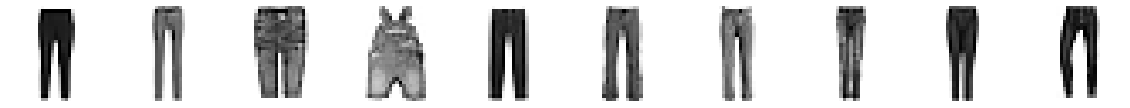

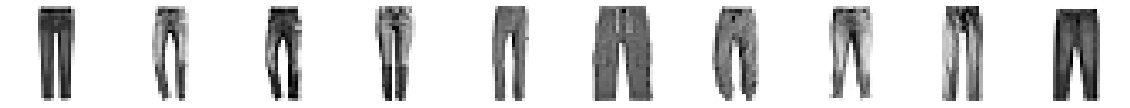

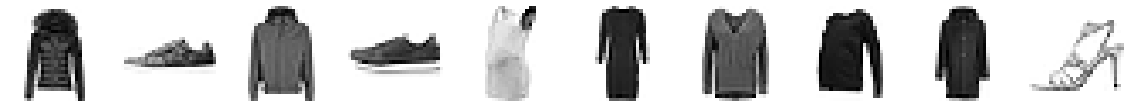

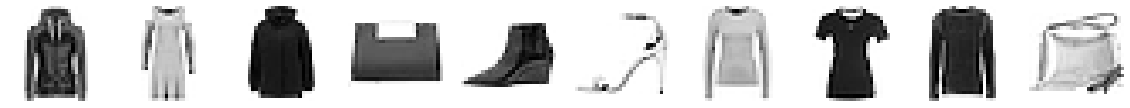

In [4]:
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(-1, 28, 28)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
    plt.show()

for loader in [anomaly_loader_train, anomaly_loader_test, normal_loader_train, normal_loader_test]:
    for (x, y) in loader:
        show_images(x)
        break

# Implement and train VAE

## *Practical assignment:*
*Design, implement, and train a VAE **on the normal training data only**. Some hints and ideas:*
* *You can stick to a fully connected architecture as in Tutorial 5.1, or try a convolutional architecture since we're dealing with images here.*
* *Make sure you only train the VAE on normal data. The idea is that the VAE learns to represent (and perform density estimation for) normal data only. Anomalous data can then (hopefully) be detected since the model hasn't been trained for it, and thus will not be able to represent it as well and will result in higher loss values (i.e. lower likelihood estimations).*
* *In Tutorial 5.1 we used a 2-dimensional latent space, mainly since it allows for easy inspection of the latent space. But a higher dimension may work better to learn a good model. If the latent dimension is too high on the other hand, your model may become too flexible, which could actually hurt your anomaly detection performance later on. A balance is needed: ideally your VAE should be flexible enough to represent the normal data well, but not so flexible that it's good at representing anomalous data as well.*


In [5]:
# hyper parameters
latent_dim = 5
x_dim = 28*28
hidden_dim = 500

lr = 1e-3
epochs = 50


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        
        return z


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr


class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        
        return x_reconstr, mu, log_sigma


cuda = True  # NOTE: if running in Google Colab, make sure to go to "Edit > Notebook settings" and set "Hardware accelerator" to "GPU"
DEVICE = torch.device("cuda" if cuda else "cpu")

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

vae = VAE(encoder=encoder, decoder=decoder).to(DEVICE)



def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=lr)

print("Start training VAE...")
vae.train()

for epoch in range(epochs):
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x, _) in enumerate(normal_loader_train):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_reconstr, mu, log_sigma = vae(x)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
    n_datapoints = batch_idx * batch_size
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")

Start training VAE...
	Epoch 1 	Average Loss:  38.23210581933412 	Reconstruction Loss: 33.68196924099896 	KL Loss: 4.550136582068477
	Epoch 2 	Average Loss:  27.85321532750174 	Reconstruction Loss: 22.061703755054936 	KL Loss: 5.791511504504145
	Epoch 3 	Average Loss:  26.63517251547281 	Reconstruction Loss: 20.410065720935037 	KL Loss: 6.225106816052948
	Epoch 4 	Average Loss:  25.87111627525655 	Reconstruction Loss: 19.4015208262371 	KL Loss: 6.469595421842388
	Epoch 5 	Average Loss:  25.525023938463878 	Reconstruction Loss: 18.965566195627755 	KL Loss: 6.559457742836126
	Epoch 6 	Average Loss:  25.28420605831111 	Reconstruction Loss: 18.669385297842503 	KL Loss: 6.614820779719025
	Epoch 7 	Average Loss:  25.08579616114912 	Reconstruction Loss: 18.43823709633001 	KL Loss: 6.647559107849461
	Epoch 8 	Average Loss:  24.959535901807456 	Reconstruction Loss: 18.24778817879247 	KL Loss: 6.711747732074008
	Epoch 9 	Average Loss:  24.838098837546383 	Reconstruction Loss: 18.101970638353 	KL

# Evaluation: reconstructions, generate data, ELBO values.

Now let's evaluate the VAE. First, we will qualitatively inspect the VAE itself, by plotting some reconstructions and generating some data (note that we can no longer plot make the 2-dimensional latent space plots from Tutorial 5.1, if we've chosen a latent dimension higher than 2).

Then, we will obtain ELBO values for all data points in both test sets (normal and anomalous), which we can then use to evaluate anomaly detection. Remember that the VAE loss function is in fact based on the **negative** ELBO, and we left out a constant term in the reconstruction loss as well. In Tutorial 5.1 we derived the reconstruction term
\begin{align}
- \log p(\textbf{x}|\textbf{z}) = \sum_{d=1}^D \left( \frac{(x_d-\mu_d)^2}{2\sigma^2} + \frac{1}{2} \log 2\pi\sigma^2 \right).
\end{align}

If we again set $\sigma = \frac{1}{\sqrt{2}}$, we see that the full term should be
\begin{align}
\sum_{d=1}^D \left( (x_d-\mu_d)^2 + \frac{1}{2} \log \pi \right) = \left(\sum_{d=1}^D  (x_d-\mu_d)^2 \right) + \frac{D}{2} \log \pi,
\end{align}
but for our loss function we left out the constant term $\frac{D}{2} \log \pi$. Let's add it back in now to compute correct ELBO values, making sure that we also take the negative values of all the loss terms, since the loss function represents the **negative** ELBO.

Furthermore, we want to obtain ELBO values for each data point individually, whereas the loss function as implemented in Tutorial 5.1 sums up the loss values for a full batch, yielding a single value per batch. We can achieve this by summing only over dim=1 (skipping dim=0, which is the batch dimension).

We can put all this together in the following function:

In [6]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

## *Practical assignment:*

* *Loop through both test sets (normal and anomalous) and use the VAE to obtain reconstructions as well as individual ELBO values for anomaly detection.*
* *Save the ELBO scores to numpy arrays, one for normal test data, one for anomalous test data.*
* *Plot some images and their reconstructions, for both the normal and anomalous test set.*
* *Generate some data by sampling latent variables from the prior, and decoding them into images.*

*Compare the reconstructions for normal data with those for anomalous data. What do you notice? Is this what you'd expect and want?*

*Also inspect the generated images. Do you recognise any trousers? Should you?*

elbo


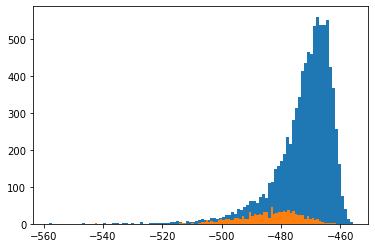

reconstruction loss
normal images


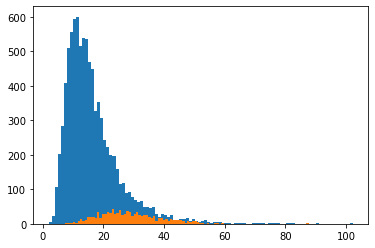

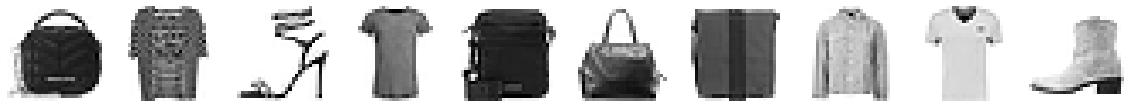

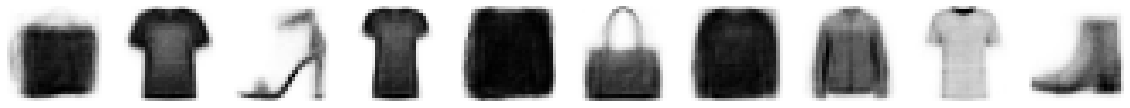

anomalous images


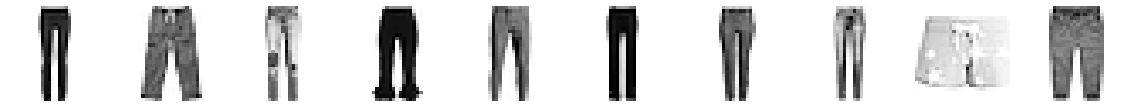

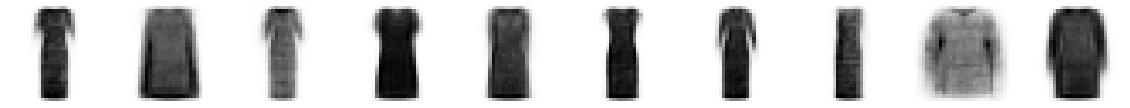

generated images


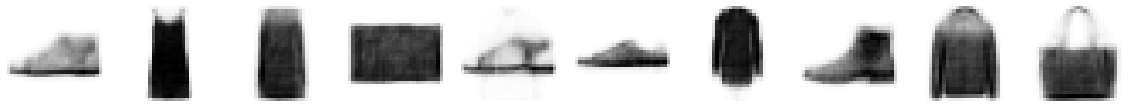

In [7]:
vae.eval()

normal_test_elbo = []
anomaly_test_elbo = []
normal_test_rec = []
anomaly_test_rec = []

with torch.no_grad():
    for x, _ in normal_loader_test:
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_rec, mu, log_sigma = vae(x)
        elbo, rec, kl = elbo_elementwise(x, x_rec, mu, log_sigma)
        normal_test_elbo.append(elbo.cpu().numpy())
        normal_test_rec.append(rec.cpu().numpy())
    
    for x, _ in anomaly_loader_test:
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_rec, mu, log_sigma = vae(x)
        elbo, rec, kl = elbo_elementwise(x, x_rec, mu, log_sigma)
        anomaly_test_elbo.append(elbo.cpu().numpy())
        anomaly_test_rec.append(rec.cpu().numpy())
    
    normal_test_elbo = np.concatenate(normal_test_elbo, 0)
    anomaly_test_elbo = np.concatenate(anomaly_test_elbo, 0)
    normal_test_rec = np.concatenate(normal_test_rec, 0)
    anomaly_test_rec = np.concatenate(anomaly_test_rec, 0)

    print('elbo')
    plt.hist(normal_test_elbo, bins=100)
    plt.hist(anomaly_test_elbo, bins=100)
    plt.show()

    print('reconstruction loss')
    plt.hist(normal_test_rec, bins=100)
    plt.hist(anomaly_test_rec, bins=100)

    for x, _ in normal_loader_test:
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_rec, _, _ = vae(x)
        print('normal images')
        x = x.cpu()
        x_rec = x_rec.cpu()
        show_images(x)
        show_images(x_rec)
        break
    
    for x, _ in anomaly_loader_test:
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_rec, _, _ = vae(x)
        print('anomalous images')
        x = x.cpu()
        x_rec = x_rec.cpu()
        show_images(x)
        show_images(x_rec)
        break

    noise = torch.randn((10, latent_dim), device=DEVICE)
    generated = decoder(noise).cpu()
    generated = generated.view(10, x_dim)
    print('generated images')
    show_images(generated)



# Anomaly Detection: density plots

We now have two sets of ELBO (= approximate likelihood) scores, one for normal test data and one for anomalous test data. Ideally, we'd want all anomalous data points to have a lower likelihood than all normal data, but this is hard to achieve in practice. Let's first visually inspect how well we did.

## *Practical assignment:*
*Visualise the ELBO scores in a histogram (`plt.hist()`) as well as a density plot (`sns.kdplot` from the `seaborn` library). Use two different colours: **green** for normal data, **red** for anomalous data, and show both normal and anomalous scores in the same plot (use transparency to make the visualisation clearer), i.e. one figure with both histograms, and one figure with both density plots.*

*Based on these plots, do you expect anomaly detection to work well?*

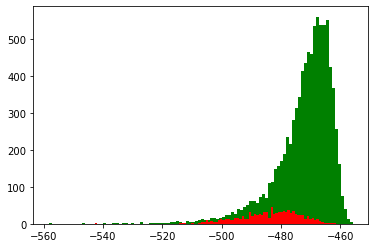

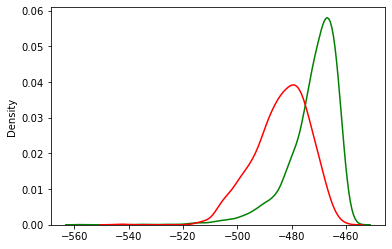

In [8]:
### INSERT CODE HERE ###
plt.hist(normal_test_elbo, bins=100, color='green')
plt.hist(anomaly_test_elbo, bins=100, color='red')
plt.show()

sns.kdeplot(normal_test_elbo, color='green')
sns.kdeplot(anomaly_test_elbo, color='red')
plt.show()


# Anomaly Detection: ROC/PR curves

Given the ELBO (= approximate likelihood) scores, we can choose a threshold and classify all instances with a likelihood below the threshold as anomalies, and all instances with a likelihood above the threshold as "normal". Different thresholds will give different True/False Positive/Negative scores. We can summarise the performance of all possible thresholds in an ROC curve, or a Precision-Recall curve (the latter has been shown to be more suitable for imbalanced datasets, see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/). In particular, the area under a ROC or Precision-Recall curve can be used as a quantitative measure to evaluate anomaly detection.

## *Practical assignment:*
* *Plot an ROC curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.*
* *Plot a Precision-Recall curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.*

*Implementation hints:*
* *See https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ for more information about ROC and PR curves and their implementation with `sklearn`.*
* *ROC/PR curves are typically used for binary classification. You can define normal as label 0 and anomaly as 1, and rescale the ELBO scores from part (a) to be between 0 and 1 (by using the minimum and maximum values in your ELBO results) to express them as binary classification probabilities.*
    * *Don't forget to "flip" the scores, low (anomalous) ELBO scores should be close to 1, whereas high (normal) ELBO scores should be close to 0.*

roc_auc=0.8216235


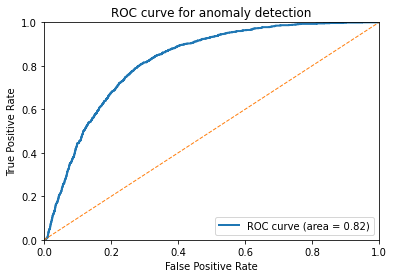

pr_auc=0.2761555589645047


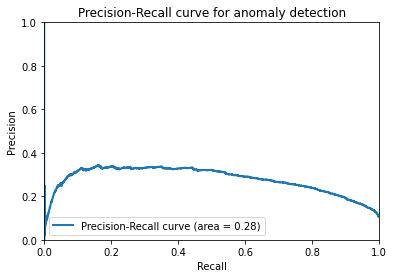

In [15]:
### INSERT CODE HERE ###
normal_test_labels = np.zeros_like(normal_test_elbo)
anomaly_test_labels = np.ones_like(anomaly_test_elbo)

scores = - np.concatenate([normal_test_elbo, anomaly_test_elbo], 0)
scores = (scores - scores.min())/(scores.max()-scores.min())

labels = np.concatenate([normal_test_labels, anomaly_test_labels], 0)
fpr, tpr, roc_thresholds = roc_curve(labels, scores)
precision, recall, pr_thresholds = precision_recall_curve(labels, scores)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

print(f'{roc_auc=}')
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for anomaly detection')
plt.legend(loc='lower right')
plt.show()


print(f'{pr_auc=}')
plt.figure()
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for anomaly detection')
plt.legend(loc='lower left')
plt.show()